In [1]:
from tools.propagate import create_photon_propagator
from tools.geometry import generate_detector
from tools.utils import load_single_event, save_single_event, print_params, generate_random_params
from tools.losses import compute_loss
from tools.simulation import setup_event_simulator

import jax
import jax.numpy as jnp
import time

from jax import jit

# uncomment to run on CPU
# jax.config.update('jax_platform_name', 'cpu')

In [2]:
default_json_filename = 'config/cyl_geom_config.json'

detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)
detector_radius = detector.S_radius
NUM_DETECTORS = len(detector_points)
Nphot = 1_000_000
temperature = 500.0

In [3]:
simulate_event = setup_event_simulator(default_json_filename, Nphot, temperature)

In [4]:
# Generate and save a single event
key = jax.random.PRNGKey(70000)

# Sample true parameter configurations:

# cone on the wall
true_params = (
    jnp.array(30.0),  # opening angle
    jnp.array([0.5, 0.0, -0.5]),  # position
    jnp.array([1.0, -1.0, 0.2]),  # direction
    jnp.array(5000.0)  # intensity
)

# fully open cone along the wall
true_params = (
    jnp.array(90.0),  # opening angle
    jnp.array([0.0, 0.0, 0.0]),  # position
    jnp.array([0.0, 1.0, 0.0]),  # direction
    jnp.array(5000.0)  # intensity
)

# Generate random parameters
true_params = generate_random_params(key)

single_event_data = simulate_event(true_params, key)

save_single_event(single_event_data, true_params, filename='events/test_event_data.h5')

'events/test_event_data.h5'

Event Parameters:
────────────────────
Opening Angle: 47.00 degrees
Initial Position: (-1.09, -1.13, -1.60)
Initial Direction: (0.50, 0.40, -0.97)
Initial Intensity: 3.29
────────────────────


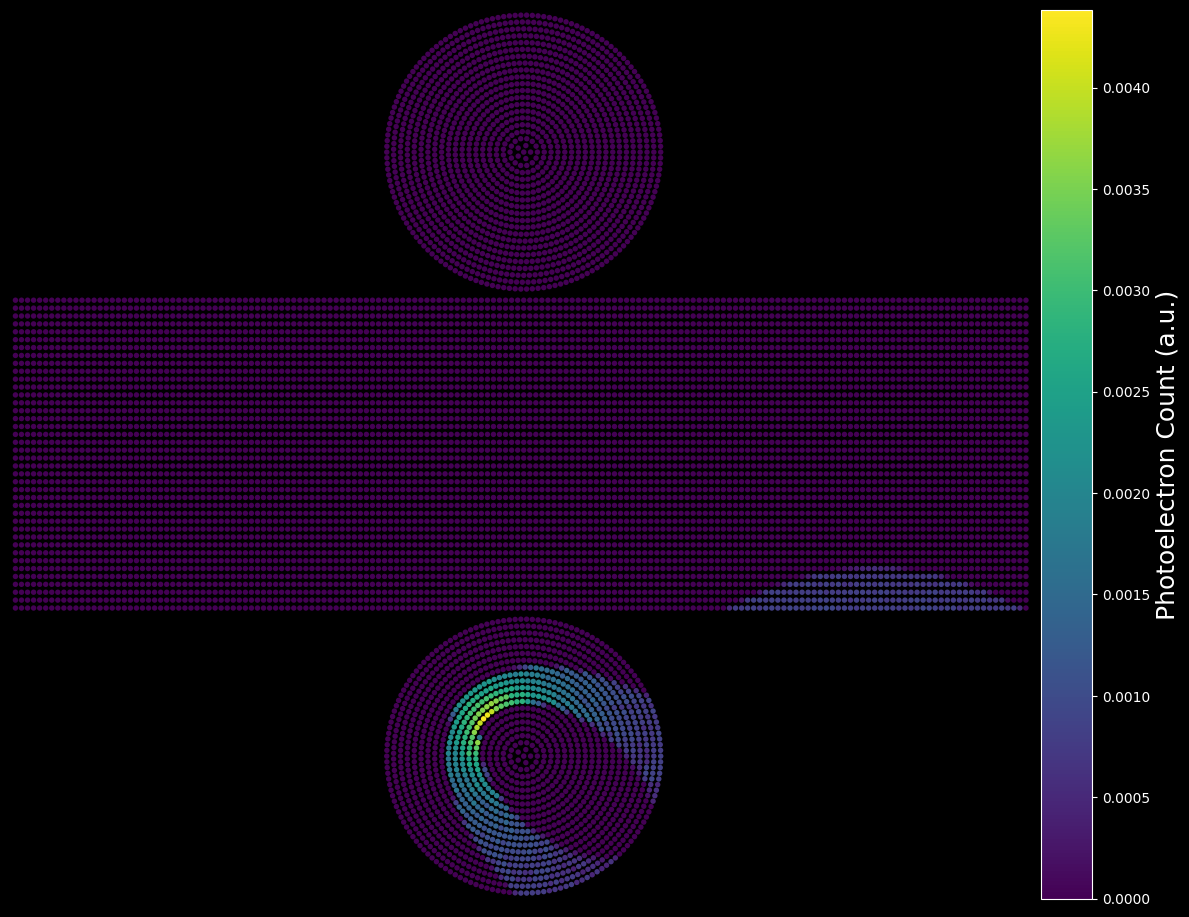

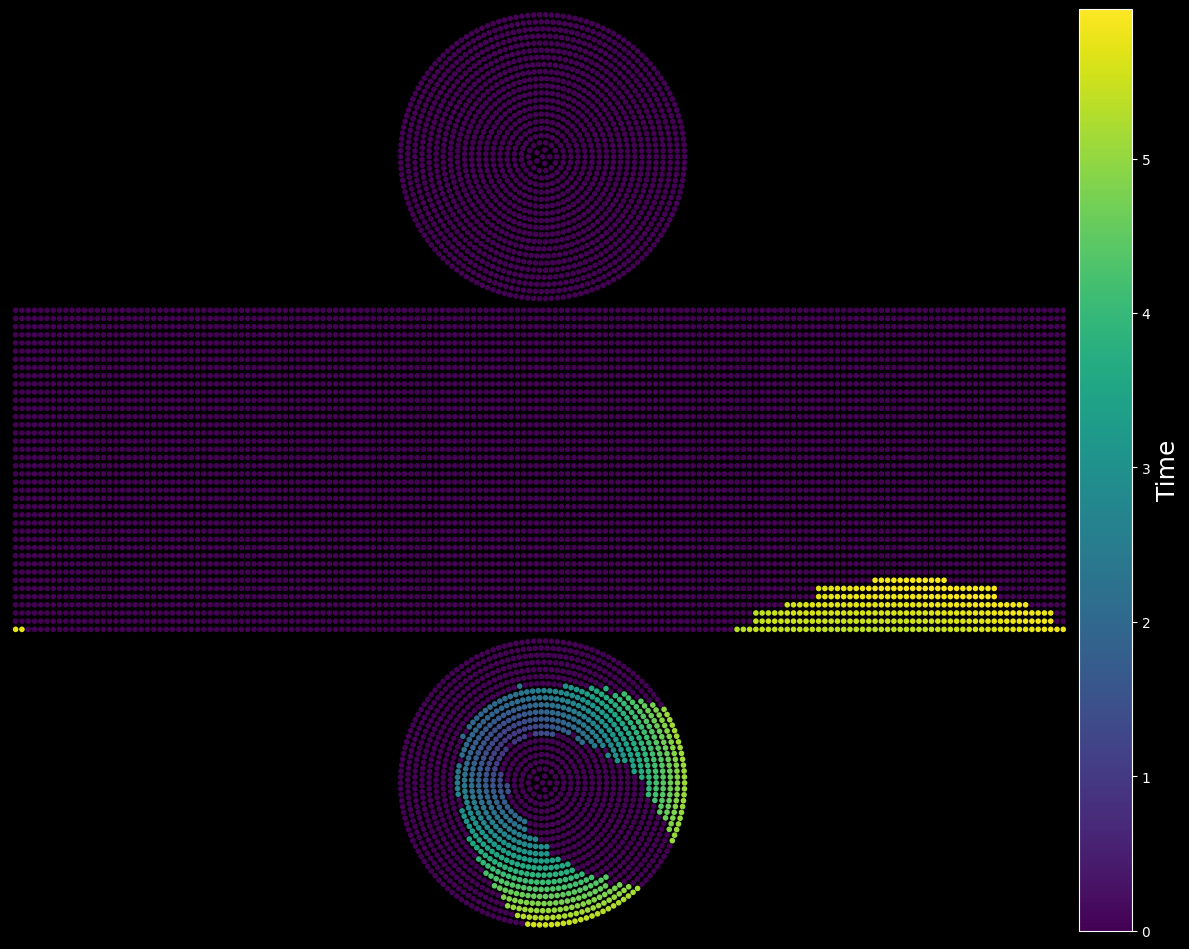

In [5]:
from tools.visualization import create_detector_display
event_location = 'events/test_event_data.h5'
loaded_params, loaded_indices, loaded_charges, loaded_times = load_single_event(event_location, NUM_DETECTORS)
print_params(loaded_params)

detector_display = create_detector_display()
detector_display(loaded_indices, loaded_charges, loaded_times, file_name='event_display.png', plot_time=False)
detector_display(loaded_indices, loaded_charges, loaded_times, file_name='event_display.png', plot_time=True)

[-0.27432868 -0.3332909  -0.34231886 -0.26455235 -0.28722718 -0.25964975
 -0.3155347  -0.36509183 -0.38509083 -0.44153985 -0.40102226 -0.45403147
 -0.44625583 -0.40535006 -0.49774075 -0.5230273  -0.58927816 -0.60124874
 -0.647177   -0.66129315 -0.60982674 -0.6196234  -0.6092485  -0.6327813
 -0.68244725 -0.68950754 -0.6685511  -0.60411954 -0.6746628  -0.630406
 -0.6626053  -0.7240935  -0.6397779  -0.70542353 -0.71592814 -0.6796947
 -0.7365066  -0.7083916  -0.7657507  -0.70224845 -0.7807941  -0.73703617
 -0.7110183  -0.7348734  -0.7307612  -0.71807134 -0.7682345  -0.74631804
 -0.65059084 -0.7708046  -0.78949404 -0.67246306 -0.71991104 -0.72282135
 -0.7346638  -0.7401134  -0.7703433  -0.79019856 -0.88099056 -0.9069175
 -0.04295452  0.93807995  0.8260733   0.7909497   0.81127506  0.7664447
  0.7766608   0.72613245  0.7608113   0.7624733   0.700522    0.6815458
  0.67219293  0.66615856  0.69700116  0.68254703  0.6532754   0.63271016
  0.695734    0.6481348   0.58582634  0.570823    0.503977

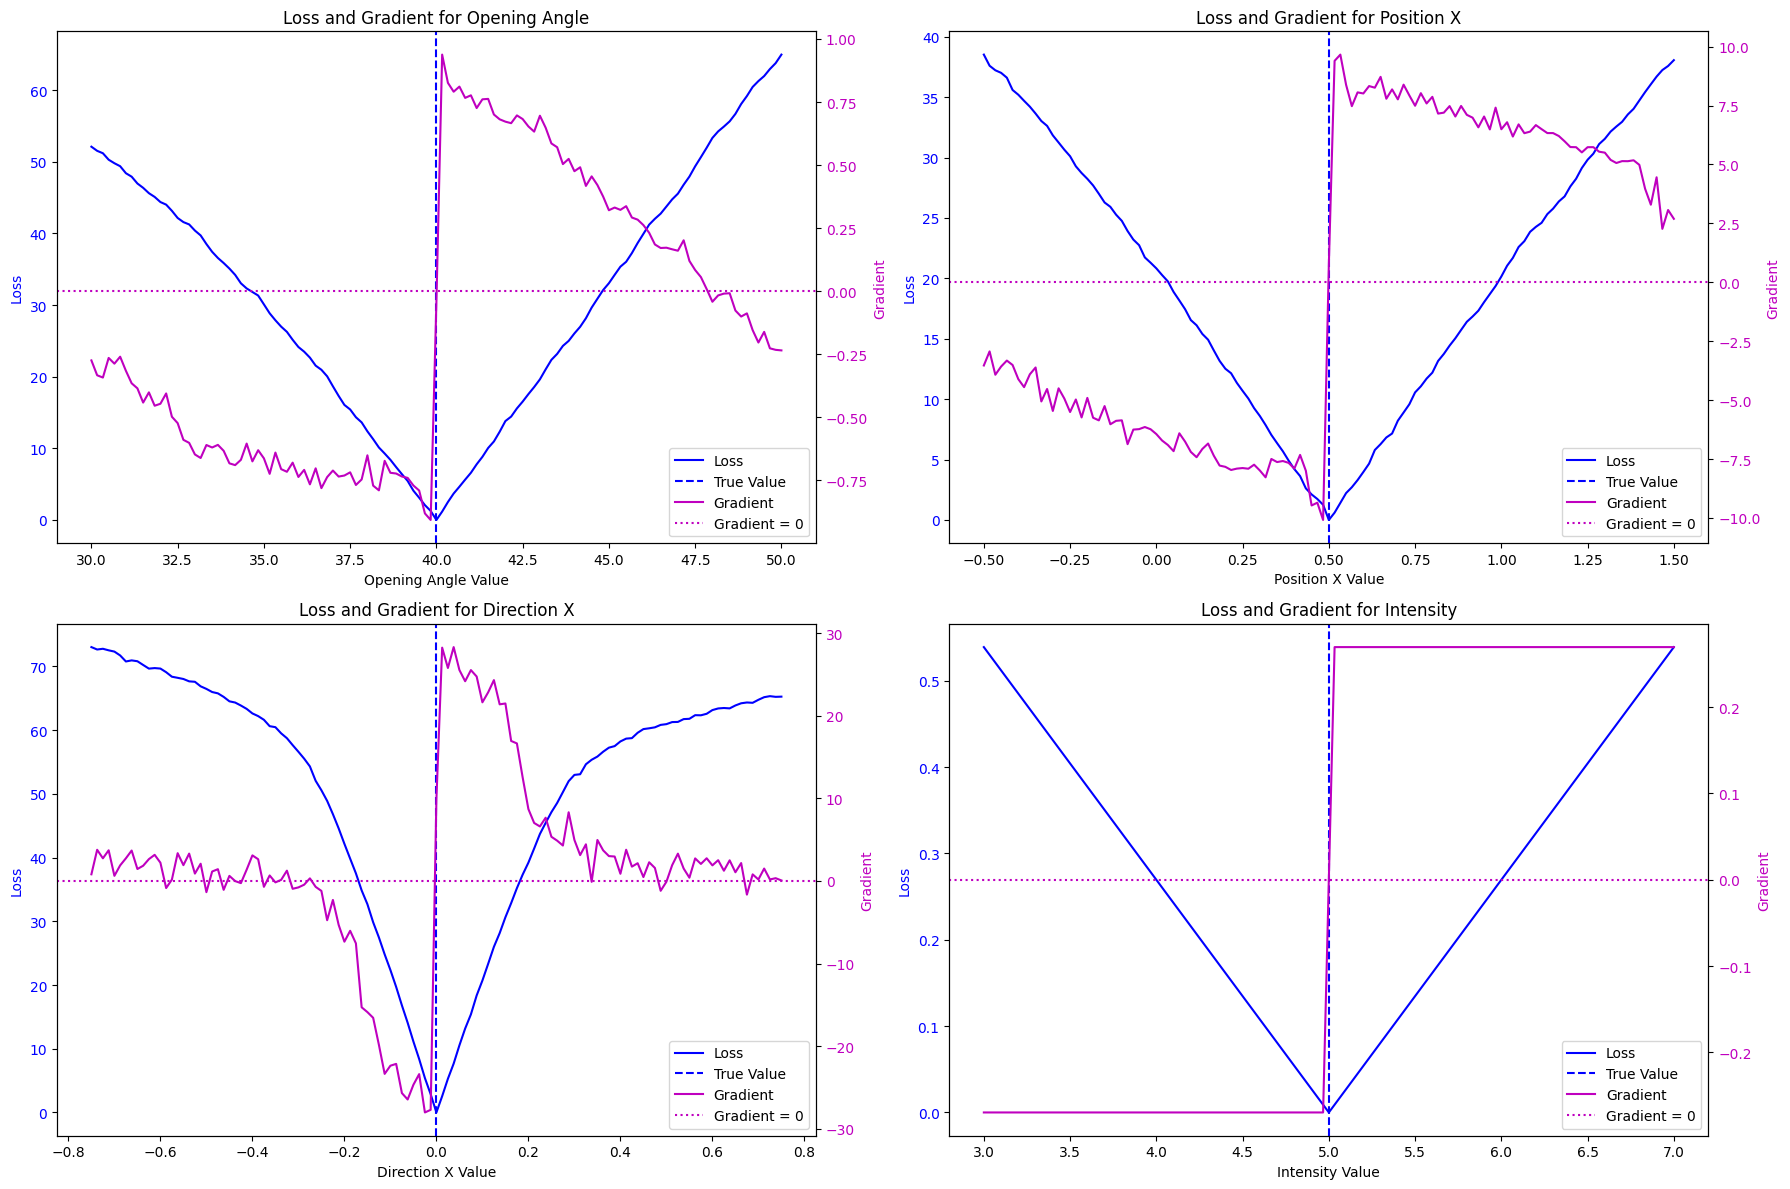

In [6]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
import matplotlib.pyplot as plt

# True parameters
true_params = (
    jnp.array(40.0),  # opening angle
    jnp.array([0.5, 0.0, 1.0]),  # position
    jnp.array([0.0, 1.0, 0.0]),  # direction
    jnp.array(5.0)  # intensity
)

# Parameter changes
param_changes = (
    jnp.array(10.0),  # opening angle
    jnp.array([1.0, 0.0, 0.0]),  # position (only changing first component)
    jnp.array([0.75, 0.0, 0.0]),  # direction (only changing first component)
    jnp.array(2.0)  # intensity
)

# Generate true data (without gradients)
key = jax.random.PRNGKey(0)

true_data_temp = jax.lax.stop_gradient(simulate_event(true_params, key))

# save data
save_single_event(true_data_temp, true_params, filename='events/true_event_data.h5')

# load data, first element is true_params
true_data = load_single_event('events/true_event_data.h5', NUM_DETECTORS, sparse=False)[1:]

def generate_param_ranges(true_params, param_changes, num_points=201):
    param_ranges = []
    for i, (true_param, change) in enumerate(zip(true_params, param_changes)):
        if i in [1, 2]:  # position and direction
            start = true_param[0] - change[0]
            end = true_param[0] + change[0]
        else:  # opening angle and intensity
            start = true_param - change
            end = true_param + change
        param_ranges.append(jnp.linspace(start, end, num_points))
    return param_ranges

@jit
def loss_and_grad(params):
    def loss_fn(params):
        simulated_data = simulate_event(params, key)
        return compute_loss(*true_data, *simulated_data)
    return value_and_grad(loss_fn)(params)

def generate_plot_data(param_index, param_values):
    losses = []
    gradients = []

    for new_value in param_values:
        new_params = list(true_params)
        if param_index in [1, 2]:  # position and direction
            new_params[param_index] = new_params[param_index].at[0].set(new_value)
        else:  # opening angle and intensity
            new_params[param_index] = new_value
        new_params = tuple(new_params)

        loss, grad = loss_and_grad(new_params)
        gradient = grad[param_index]
        if param_index in [1, 2]:
            gradient = gradient[0]

        losses.append(loss)
        gradients.append(gradient)

    return jnp.array(losses), jnp.array(gradients)

# Generate parameter ranges
num_points = 121
param_ranges = generate_param_ranges(true_params, param_changes, num_points)

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
param_names = ['Opening Angle', 'Position X', 'Direction X', 'Intensity']

for i, (row, col) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    param_values = param_ranges[i]
    losses, gradients = generate_plot_data(i, param_values)

    print(gradients)
    
    ax1 = axs[row, col]
    ax2 = ax1.twinx()
    
    ax1.plot(param_values, losses, 'b-', label='Loss')
    ax2.plot(param_values, gradients, 'm-', label='Gradient')
    
    # Add vertical line at the center (true parameter value)
    true_value = true_params[i] if i not in [1, 2] else true_params[i][0]
    ax1.axvline(x=true_value, color='b', linestyle='--', label='True Value')
    
    # Add horizontal line for gradient at zero
    ax2.axhline(y=0, color='m', linestyle=':', label='Gradient = 0')
    
    ax1.set_xlabel(f'{param_names[i]} Value')
    ax1.set_ylabel('Loss', color='b')
    ax2.set_ylabel('Gradient', color='m')
    
    ax1.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='m')
    
    ax1.set_title(f'Loss and Gradient for {param_names[i]}')
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.tight_layout()
plt.show()

In [7]:
# 2D Valley Analysis
# This is the case where we move closer to the wall and increase the opening angle. The gradient is the steepest in the direction of the valley.

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
import matplotlib.pyplot as plt

# True parameters
true_params = (
    jnp.array(40.0),  # opening angle
    jnp.array([0.0, 0.0, 0.0]),  # position
    jnp.array([1.0, 0.0, 0.0]),  # direction
    jnp.array(5.0)  # intensity
)

# Parameter changes
param_changes = (
    jnp.array(5.0),  # opening angle
    jnp.array([0.5, 0.0, 0.0]),  # position (only changing first component)
    jnp.array([0.25, 0.0, 0.0]),  # direction (only changing first component)
    jnp.array(2.0)  # intensity
)

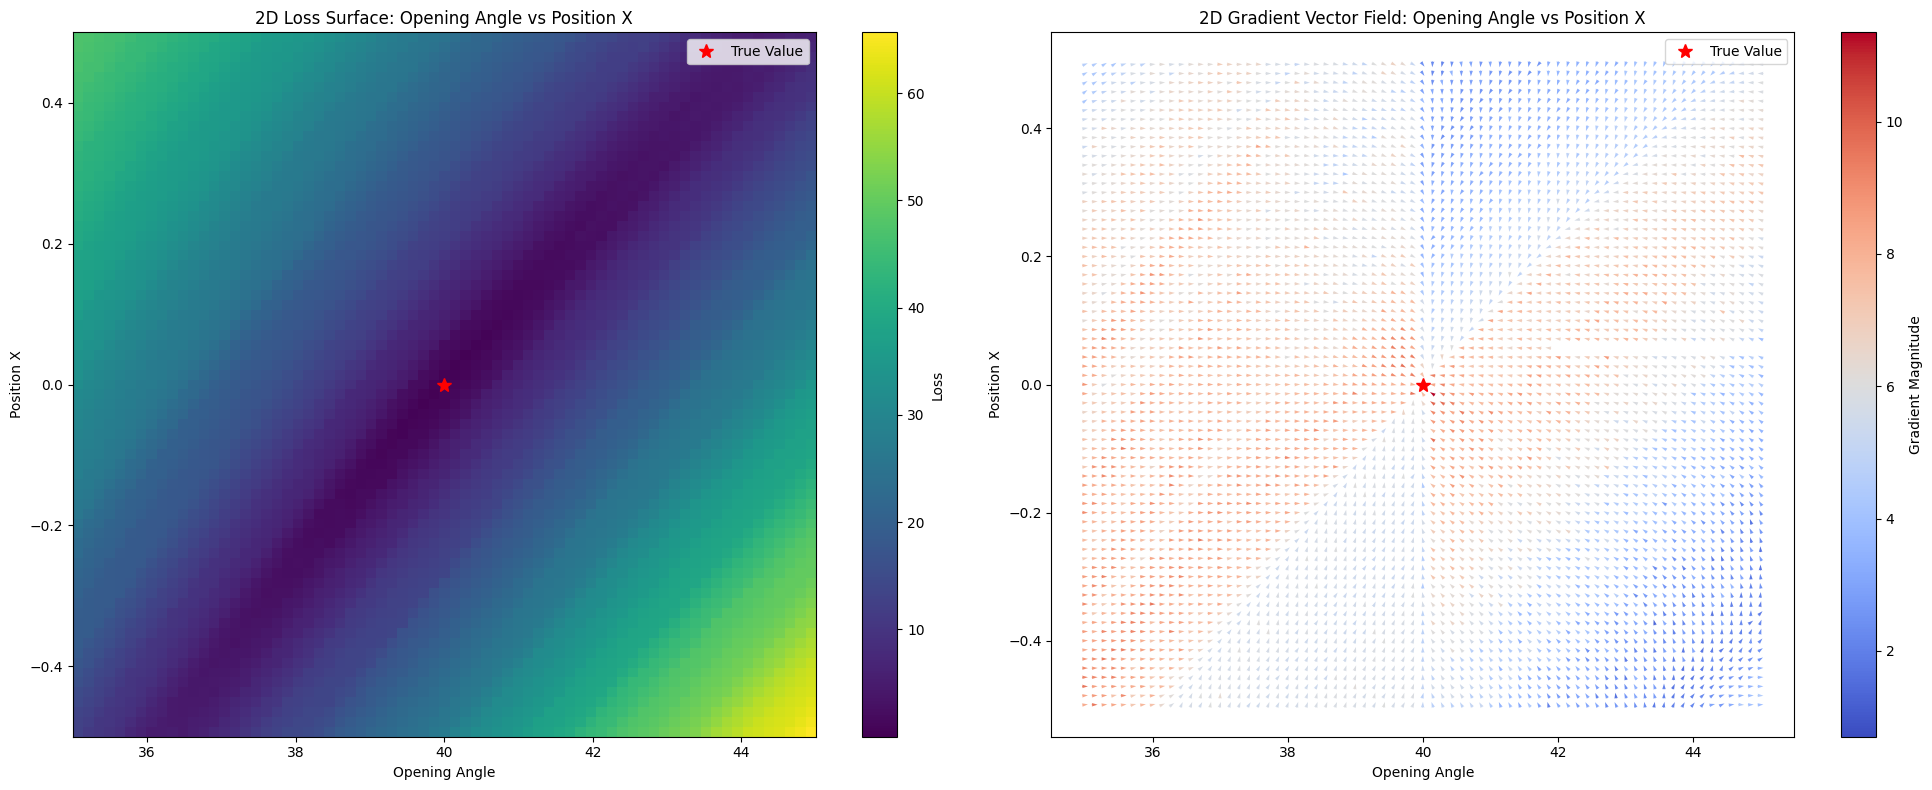

In [8]:
# Gradient scales
gradient_scales = jnp.array([0.1, 1, 5, 0.5])
# gradient_scales = jnp.array([1.0, 1.0, 1.0, 1.0])

# Generate true data (without gradients)
key = jax.random.PRNGKey(1)
true_data = jax.lax.stop_gradient(simulate_event(true_params, key))

true_data = (true_data[0], true_data[1])

def generate_param_ranges(true_params, param_changes, num_points=51):
    param_ranges = []
    for i, (true_param, change) in enumerate(zip(true_params, param_changes)):
        if i in [1, 2]:  # position and direction
            start = true_param[0] - change[0]
            end = true_param[0] + change[0]
        else:  # opening angle and intensity
            start = true_param - change
            end = true_param + change
        param_ranges.append(jnp.linspace(start, end, num_points))
    return param_ranges

@jit
def loss_and_grad(params):
    def loss_fn(params):
        simulated_data = simulate_event(params, key)
        return compute_loss(*true_data, *simulated_data, sigma_time=100)
    return value_and_grad(loss_fn)(params)

def generate_2d_plot_data(param_index1, param_index2, param_values1, param_values2):
    losses = jnp.zeros((len(param_values1), len(param_values2)))
    gradients = jnp.zeros((len(param_values1), len(param_values2), 2))

    for i, value1 in enumerate(param_values1):
        for j, value2 in enumerate(param_values2):
            new_params = list(true_params)

            if param_index1 in [1, 2]:
                new_params[param_index1] = new_params[param_index1].at[0].set(value1)
            else:
                new_params[param_index1] = value1

            if param_index2 in [1, 2]:
                new_params[param_index2] = new_params[param_index2].at[0].set(value2)
            else:
                new_params[param_index2] = value2

            new_params = tuple(new_params)

            loss, grad = loss_and_grad(new_params)
            gradient1 = grad[param_index1][0] if param_index1 in [1, 2] else grad[param_index1]
            gradient2 = grad[param_index2][0] if param_index2 in [1, 2] else grad[param_index2]

            # Rescale gradients
            gradient1 /= gradient_scales[param_index1]
            gradient2 /= gradient_scales[param_index2]

            losses = losses.at[i, j].set(loss)
            gradients = gradients.at[i, j].set(jnp.array([gradient1, gradient2]))

    return losses, gradients

# Generate parameter ranges
num_points = 71
param_ranges = generate_param_ranges(true_params, param_changes, num_points)

# Choose two parameters to vary (e.g., opening angle and intensity)
param_index1, param_index2 = 0, 1
param_names = ['Opening Angle', 'Position X', 'Direction X', 'Intensity']

# Generate 2D plot data
losses, gradients = generate_2d_plot_data(param_index1, param_index2, param_ranges[param_index1], param_ranges[param_index2])

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 2D loss surface
im = ax1.imshow(losses.T, extent=[param_ranges[param_index1][0], param_ranges[param_index1][-1],
                                  param_ranges[param_index2][0], param_ranges[param_index2][-1]],
                origin='lower', aspect='auto', cmap='viridis')
ax1.set_title(f'2D Loss Surface: {param_names[param_index1]} vs {param_names[param_index2]}')
ax1.set_xlabel(param_names[param_index1])
ax1.set_ylabel(param_names[param_index2])
fig.colorbar(im, ax=ax1, label='Loss')

# Plot 2D gradient vector field
X, Y = jnp.meshgrid(param_ranges[param_index1], param_ranges[param_index2])
U = -1 * gradients[:, :, 0].T
V = -1 * gradients[:, :, 1].T

# Normalize gradients for better visualization
norm = jnp.sqrt(U**2 + V**2)
U_norm = U / norm
V_norm = V / norm

ax2.quiver(X, Y, U_norm, V_norm, norm, cmap='coolwarm', pivot='mid')
ax2.set_title(f'2D Gradient Vector Field: {param_names[param_index1]} vs {param_names[param_index2]}')
ax2.set_xlabel(param_names[param_index1])
ax2.set_ylabel(param_names[param_index2])
fig.colorbar(ax2.collections[0], ax=ax2, label='Gradient Magnitude')

# Add markers for true parameter values
true_value1 = true_params[param_index1] if param_index1 not in [1, 2] else true_params[param_index1][0]
true_value2 = true_params[param_index2] if param_index2 not in [1, 2] else true_params[param_index2][0]
ax1.plot(true_value1, true_value2, 'r*', markersize=10, label='True Value')
ax2.plot(true_value1, true_value2, 'r*', markersize=10, label='True Value')

ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


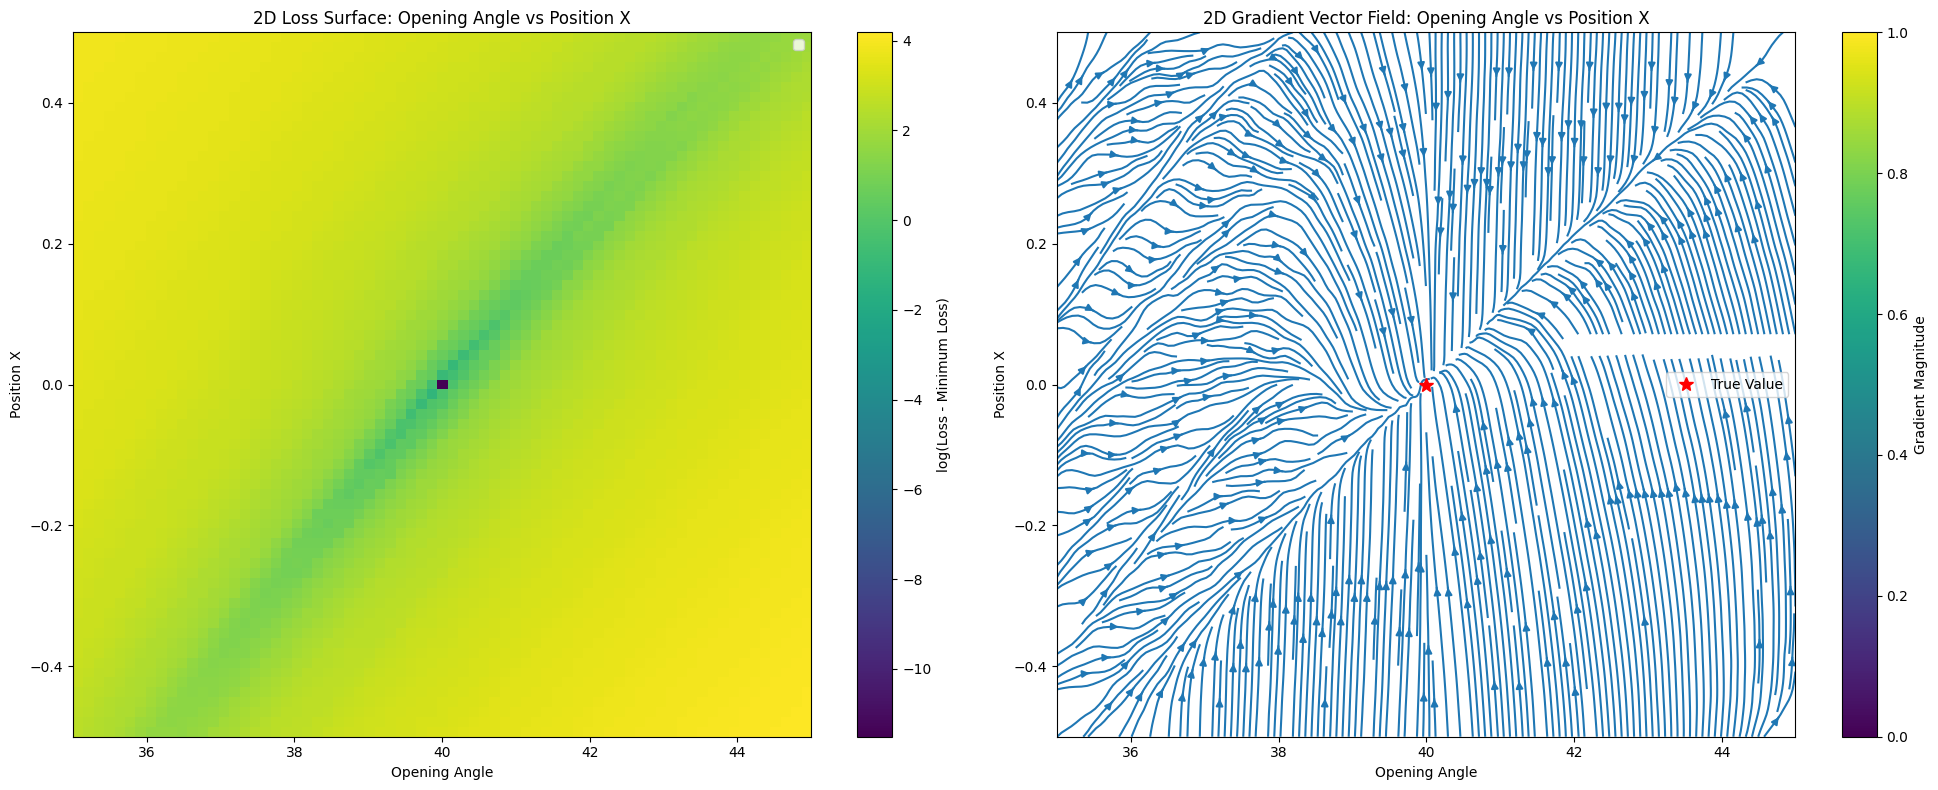

In [9]:
import numpy as np

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 2D loss surface
im = ax1.imshow(np.log(losses.T-np.min(losses)+1e-5), extent=[param_ranges[param_index1][0], param_ranges[param_index1][-1],
                                  param_ranges[param_index2][0], param_ranges[param_index2][-1]],
                origin='lower', aspect='auto', cmap='viridis')
ax1.set_title(f'2D Loss Surface: {param_names[param_index1]} vs {param_names[param_index2]}')
ax1.set_xlabel(param_names[param_index1])
ax1.set_ylabel(param_names[param_index2])
fig.colorbar(im, ax=ax1, label='log(Loss - Minimum Loss)')

# Plot 2D gradient vector field
X, Y = jnp.meshgrid(param_ranges[param_index1], param_ranges[param_index2])

# Create equally spaced arrays
x = np.linspace(param_ranges[param_index1][0], param_ranges[param_index1][-1], len(param_ranges[param_index1]))
y = np.linspace(param_ranges[param_index2][0], param_ranges[param_index2][-1], len(param_ranges[param_index2]))

# Generate meshgrid
X, Y = np.meshgrid(x, y)

U = -1 * gradients[:, :, 0].T
V = -1 * gradients[:, :, 1].T

# Normalize gradients for better visualization
norm = jnp.sqrt(U**2 + V**2)
U_norm = U / norm
V_norm = V / norm

# ax2.quiver(X, Y, U_norm, V_norm, norm, cmap='coolwarm', pivot='mid')
ax2.streamplot(X, Y, U_norm, V_norm, norm=norm, cmap='coolwarm', density = 4)
ax2.set_title(f'2D Gradient Vector Field: {param_names[param_index1]} vs {param_names[param_index2]}')
ax2.set_xlabel(param_names[param_index1])
ax2.set_ylabel(param_names[param_index2])
fig.colorbar(ax2.collections[0], ax=ax2, label='Gradient Magnitude')

# Add markers for true parameter values
true_value1 = true_params[param_index1] if param_index1 not in [1, 2] else true_params[param_index1][0]
true_value2 = true_params[param_index2] if param_index2 not in [1, 2] else true_params[param_index2][0]
# ax1.plot(true_value1, true_value2, 'r*', markersize=10, label='True Value')
ax2.plot(true_value1, true_value2, 'r*', markersize=10, label='True Value')

ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()

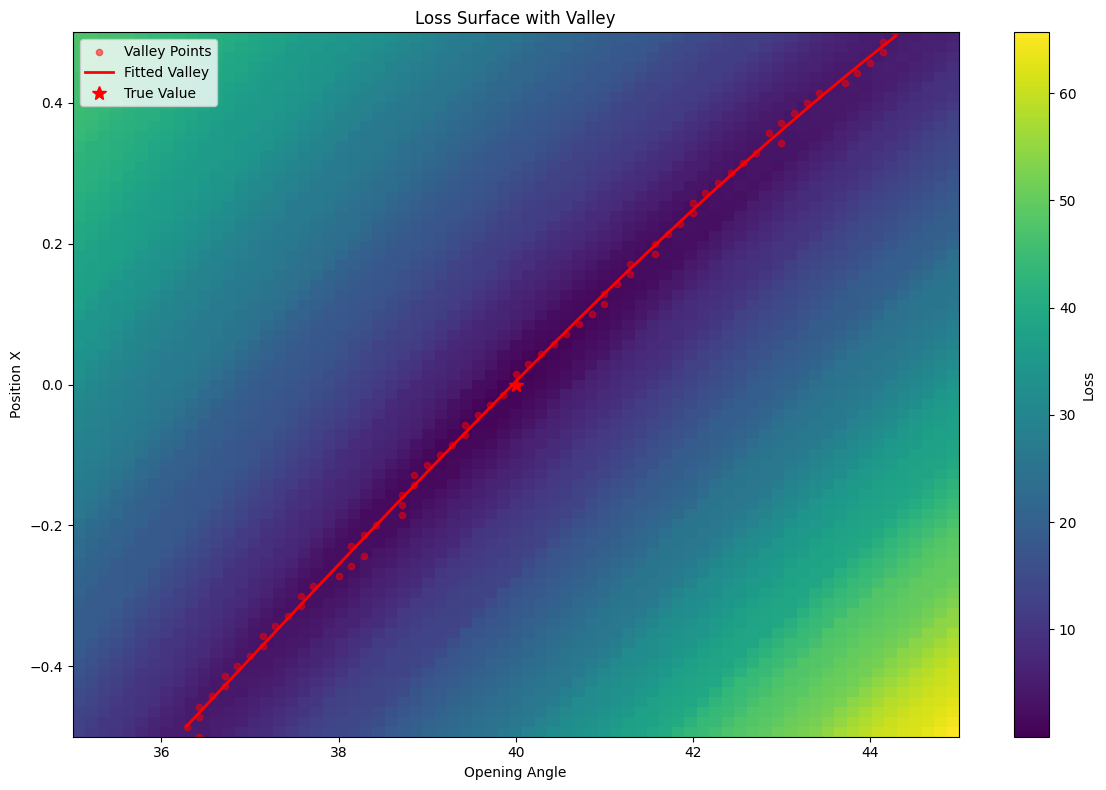

In [10]:
def analyze_valley_fit(losses, param_ranges, true_params, param_indices, param_names, 
                      order=3, num_points=300):
    """
    First step: Find and plot the valley curve.
    """
    param_index1, param_index2 = param_indices
    
    # Find valley points
    valley_indices = np.argmin(losses, axis=0)
    valley_x = param_ranges[0][valley_indices]
    valley_y = param_ranges[1]
    
    # Fit polynomial
    coeffs = np.polyfit(valley_x, valley_y, order)
    x_smooth = np.linspace(valley_x.min(), valley_x.max(), num_points)
    y_smooth = np.polyval(coeffs, x_smooth)
    deriv_coeffs = np.polyder(coeffs)
    dy_dx = np.polyval(deriv_coeffs, x_smooth)
    
    # Plot results
    x_range = param_ranges[0][-1] - param_ranges[0][0]
    y_range = param_ranges[1][-1] - param_ranges[1][0]
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    
    im = ax.imshow(losses.T, 
                   extent=[param_ranges[0][0], param_ranges[0][-1],
                          param_ranges[1][0], param_ranges[1][-1]],
                   origin='lower', aspect='auto', cmap='viridis')
    
    ax.scatter(valley_x, valley_y, c='r', s=20, alpha=0.5, label='Valley Points')
    ax.plot(x_smooth, y_smooth, 'r-', lw=2, label='Fitted Valley')
    ax.plot(true_params[0], true_params[1][0], 'r*', markersize=10, label='True Value')
    
    ax.set_xlabel(param_names[0])
    ax.set_ylabel(param_names[1])
    ax.set_title('Loss Surface with Valley')
    
    fig.colorbar(im, ax=ax, label='Loss')
    ax.legend()
    # ax.set_aspect('equal')
    plt.tight_layout()
    
    valley_curve = (x_smooth, y_smooth, dy_dx)
    valley_points = (valley_x, valley_y)
    
    return valley_points, valley_curve, fig

valley_points, valley_curve, fig = analyze_valley_fit(losses, param_ranges, true_params, (0, 1), param_names, num_points=300)

In [12]:
# save valley_curve as npy
np.save('valley_curve.npy', valley_curve)

# load valley_curve
# valley_curve = np.load('valley_curve.npy', allow_pickle=True)

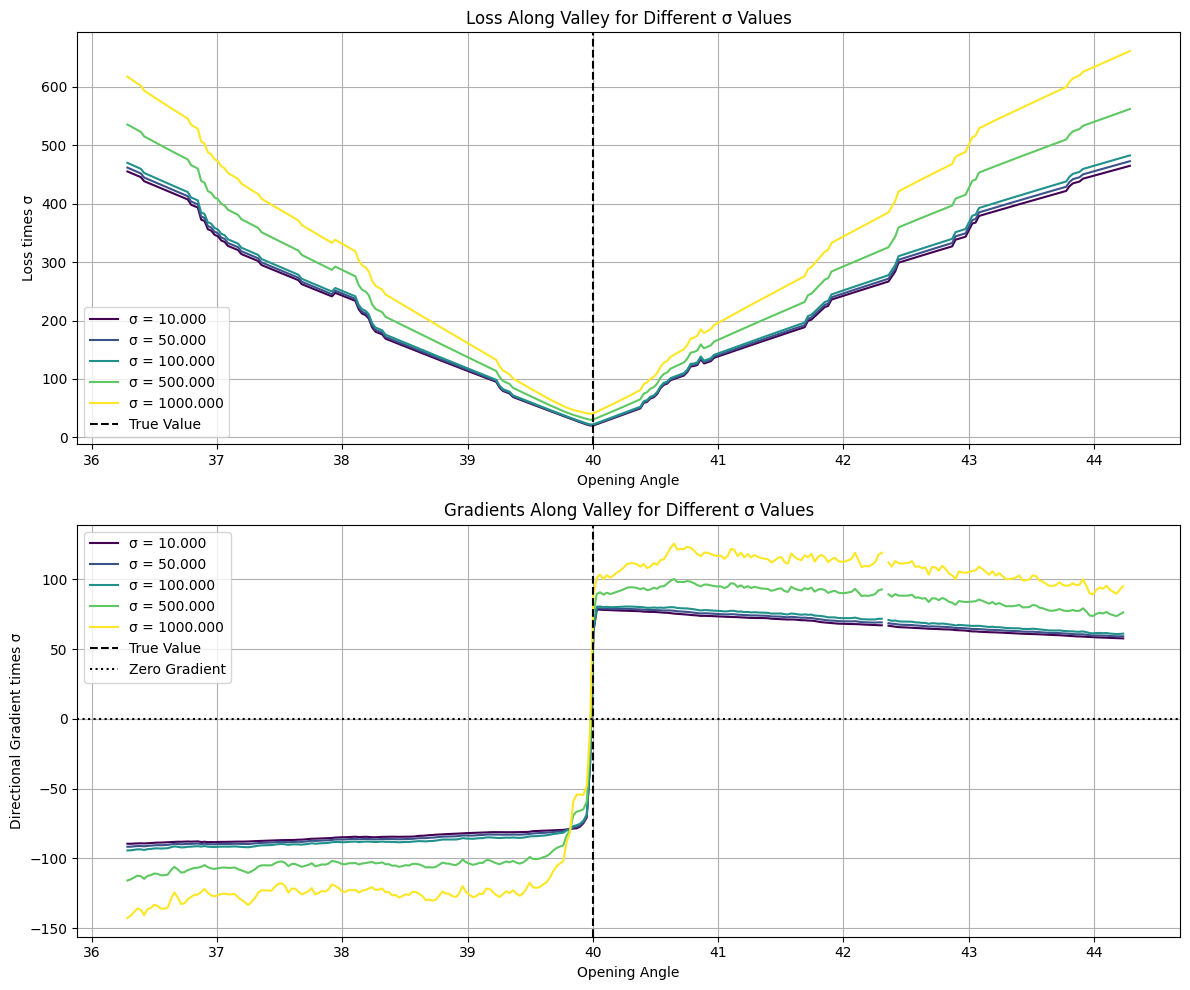

In [13]:
def analyze_valley_gradients(valley_curve, loss_and_grad, true_params, param_indices, param_names, sigma_values):
    """
    Second step: Compute and plot gradients for different sigma values.
    """
    x_smooth, y_smooth, dy_dx = valley_curve
    param_index1, param_index2 = param_indices
    
    # Colors for different sigma values
    colors = plt.cm.viridis(np.linspace(0, 1, len(sigma_values)))
    
    # Initialize lists to store results
    all_losses = []
    all_gradients = []
    
    # Compute gradients for each sigma value
    for sigma in sigma_values:
        valley_losses = []
        directional_gradients = []
        
        for x, y, slope in zip(x_smooth, y_smooth, dy_dx):
            # Create parameter set
            new_params = list(true_params)
            new_params[param_index1] = x
            new_params[param_index2] = new_params[param_index2].at[0].set(y)
            new_params = tuple(new_params)
            
            # Compute loss and gradient with current sigma
            loss, grad = loss_and_grad(new_params, sigma_time=sigma)
            
            gradient1 = grad[param_index1]
            gradient2 = grad[param_index2][0]
            
            valley_direction = np.array([1.0, slope])
            valley_direction /= np.linalg.norm(valley_direction)
            
            gradient_vector = np.array([gradient1, gradient2])
            directional_grad = np.dot(gradient_vector, valley_direction)
            
            valley_losses.append(float(loss))
            directional_gradients.append(float(directional_grad))
        
        all_losses.append(np.array(valley_losses))
        all_gradients.append(np.array(directional_gradients))
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot losses
    for i, (losses, sigma) in enumerate(zip(all_losses, sigma_values)):
        ax1.plot(x_smooth, losses*sigma, color=colors[i],
                label=f'σ = {sigma:.3f}')
    ax1.axvline(x=float(true_params[0]), color='k', linestyle='--', label='True Value')
    ax1.set_xlabel(param_names[0])
    ax1.set_ylabel('Loss times σ')
    ax1.set_title('Loss Along Valley for Different σ Values')
    ax1.legend()
    ax1.grid(True)
    
    # Plot gradients
    for i, (grads, sigma) in enumerate(zip(all_gradients, sigma_values)):
        ax2.plot(x_smooth, grads*sigma, color=colors[i],
                label=f'σ = {sigma:.3f}')
    ax2.axvline(x=float(true_params[0]), color='k', linestyle='--', label='True Value')
    ax2.axhline(y=0, color='k', linestyle=':', label='Zero Gradient')
    ax2.set_xlabel(param_names[0])
    ax2.set_ylabel('Directional Gradient times σ')
    ax2.set_title('Gradients Along Valley for Different σ Values')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    
    return all_losses, all_gradients, fig

# Then analyze gradients with different sigma values
sigma_values = [50.0, 100.0, 500.0, 1000.0]  # adjust as needed

# Wrap the loss_and_grad function to include sigma
def loss_and_grad_with_sigma(params, sigma_time):
    def loss_fn(params):
        simulated_data = simulate_event(params, key)
        return compute_loss(*true_data, *simulated_data, 
                          sigma_time=sigma_time)
    return value_and_grad(loss_fn)(params)

all_losses, all_gradients, fig2 = analyze_valley_gradients(
    valley_curve,
    loss_and_grad_with_sigma,
    true_params,
    (param_index1, param_index2),
    ['Opening Angle', 'Position X'],
    sigma_values
)
plt.show()